In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Data Preparation and Underestanding

## Loading the source and target dataset
Nasa Turbofan Engine Remaining Lifetime dataset
(https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan )

In this tutorial, FD1 (one operating condition and one type of fault) and FD4 (six operating conditions and two types of faults) were used.

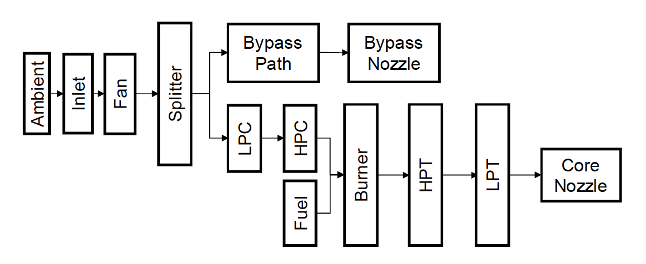

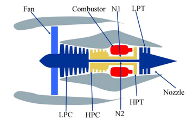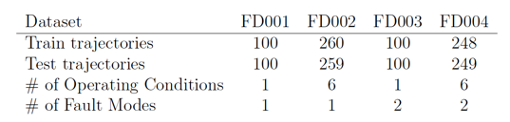

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id_train1 = '1EvNPwZ6WW_TmiddL_dERnr-aaVllLV_C'
downloaded = drive.CreateFile({'id': file_id_train1})
downloaded.GetContentFile('fd1_train.csv')
print(os.listdir())
df_source=pd.read_csv('fd1_train.csv')
#https://drive.google.com/file/d/1LXwdo7VlBLk_akoXnMaZB_nB_FOXVWu6/view?usp=sharing
#https://drive.google.com/file/d/1Dbq_DuRxHvpMip-KorYPjjCnCZVVMTUH/view?usp=sharing
file_id_train4 = '1LXwdo7VlBLk_akoXnMaZB_nB_FOXVWu6'
downloaded = drive.CreateFile({'id': file_id_train4})
downloaded.GetContentFile('fd4_train.csv')
print(os.listdir())
df_target=pd.read_csv('fd4_train.csv')

['.config', 'fd1_train.csv', 'sample_data']
['.config', 'fd4_train.csv', 'fd1_train.csv', 'sample_data']


In [4]:
print("source data: \n", df_source)
print("target data: \n", df_target)

source data: 
         id  cycle      s1      s2     s3      s4      s5       s6       s7  \
0        1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1        1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2        1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3        1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4        1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
...    ...    ...     ...     ...    ...     ...     ...      ...      ...   
20626  100    196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63   
20627  100    197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58   
20628  100    198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18   
20629  100    199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53   
20630  100    200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14   

          s8  ...      s16      s17     s18   s1

## Rreminaing useful life (RUL) with plateau
RUL parameter is consider as the value which we want to predict. basically we consider any unit that has RUL >= 130 cycles as healthy (enough) equipment.

In [14]:
df_source.loc[df_source["rul"]>=130, "rul"] = 130
df_target.loc[df_target["rul"]>=130, "rul"] = 130

## Visualizing the data
* Plotting values of sensor 5 and operating cycle for engine number 1. 
* Plotting the corresponding RUL values and operating cycle for engine number 1.

<Figure size 640x480 with 0 Axes>

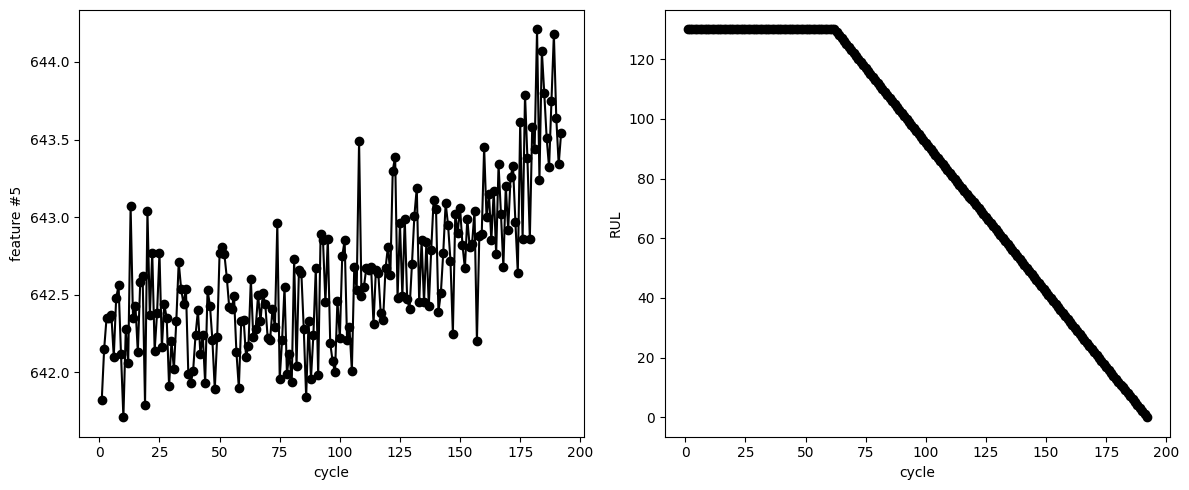

In [15]:
X_ds = df_source[df_source["id"] == 1]

plt.clf()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)
axs[0].plot(X_ds["cycle"], X_ds["s5"], '-ok')
axs[1].plot(X_ds["cycle"], X_ds["rul"], '-ok')

axs[0].set_xlabel("cycle")
axs[0].set_ylabel("feature #5")

axs[1].set_xlabel("cycle")
axs[1].set_ylabel("RUL")

fig.tight_layout()
plt.show()



* plotting the same feature 5 for engine unit 1 for both source and target domain
  * Do they look similar?

<Figure size 640x480 with 0 Axes>

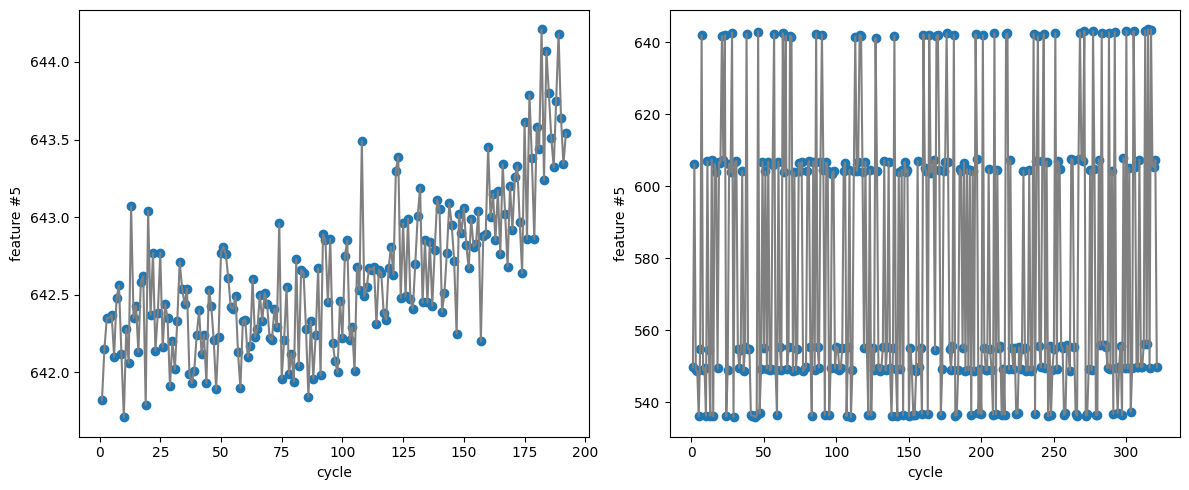

In [16]:
X_ds = df_source[df_source["id"] == 1]
X_dt = df_target[df_target["id"] == 1]

plt.clf()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))#, sharey=True)
axs[0].scatter(X_ds["cycle"], X_ds["s5"])
axs[0].plot(X_ds["cycle"], X_ds["s5"], c="gray")
#axs[0].set_ylim([])

axs[1].scatter(X_dt["cycle"], X_dt["s5"])
axs[1].plot(X_dt["cycle"], X_dt["s5"], c="gray")

axs[0].set_xlabel("cycle")
axs[0].set_ylabel("feature #5")

axs[1].set_xlabel("cycle")
axs[1].set_ylabel("feature #5")

fig.tight_layout()
plt.show()



visualizing all features for engine unit 1 in the target doamin

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24']


<Figure size 640x480 with 0 Axes>

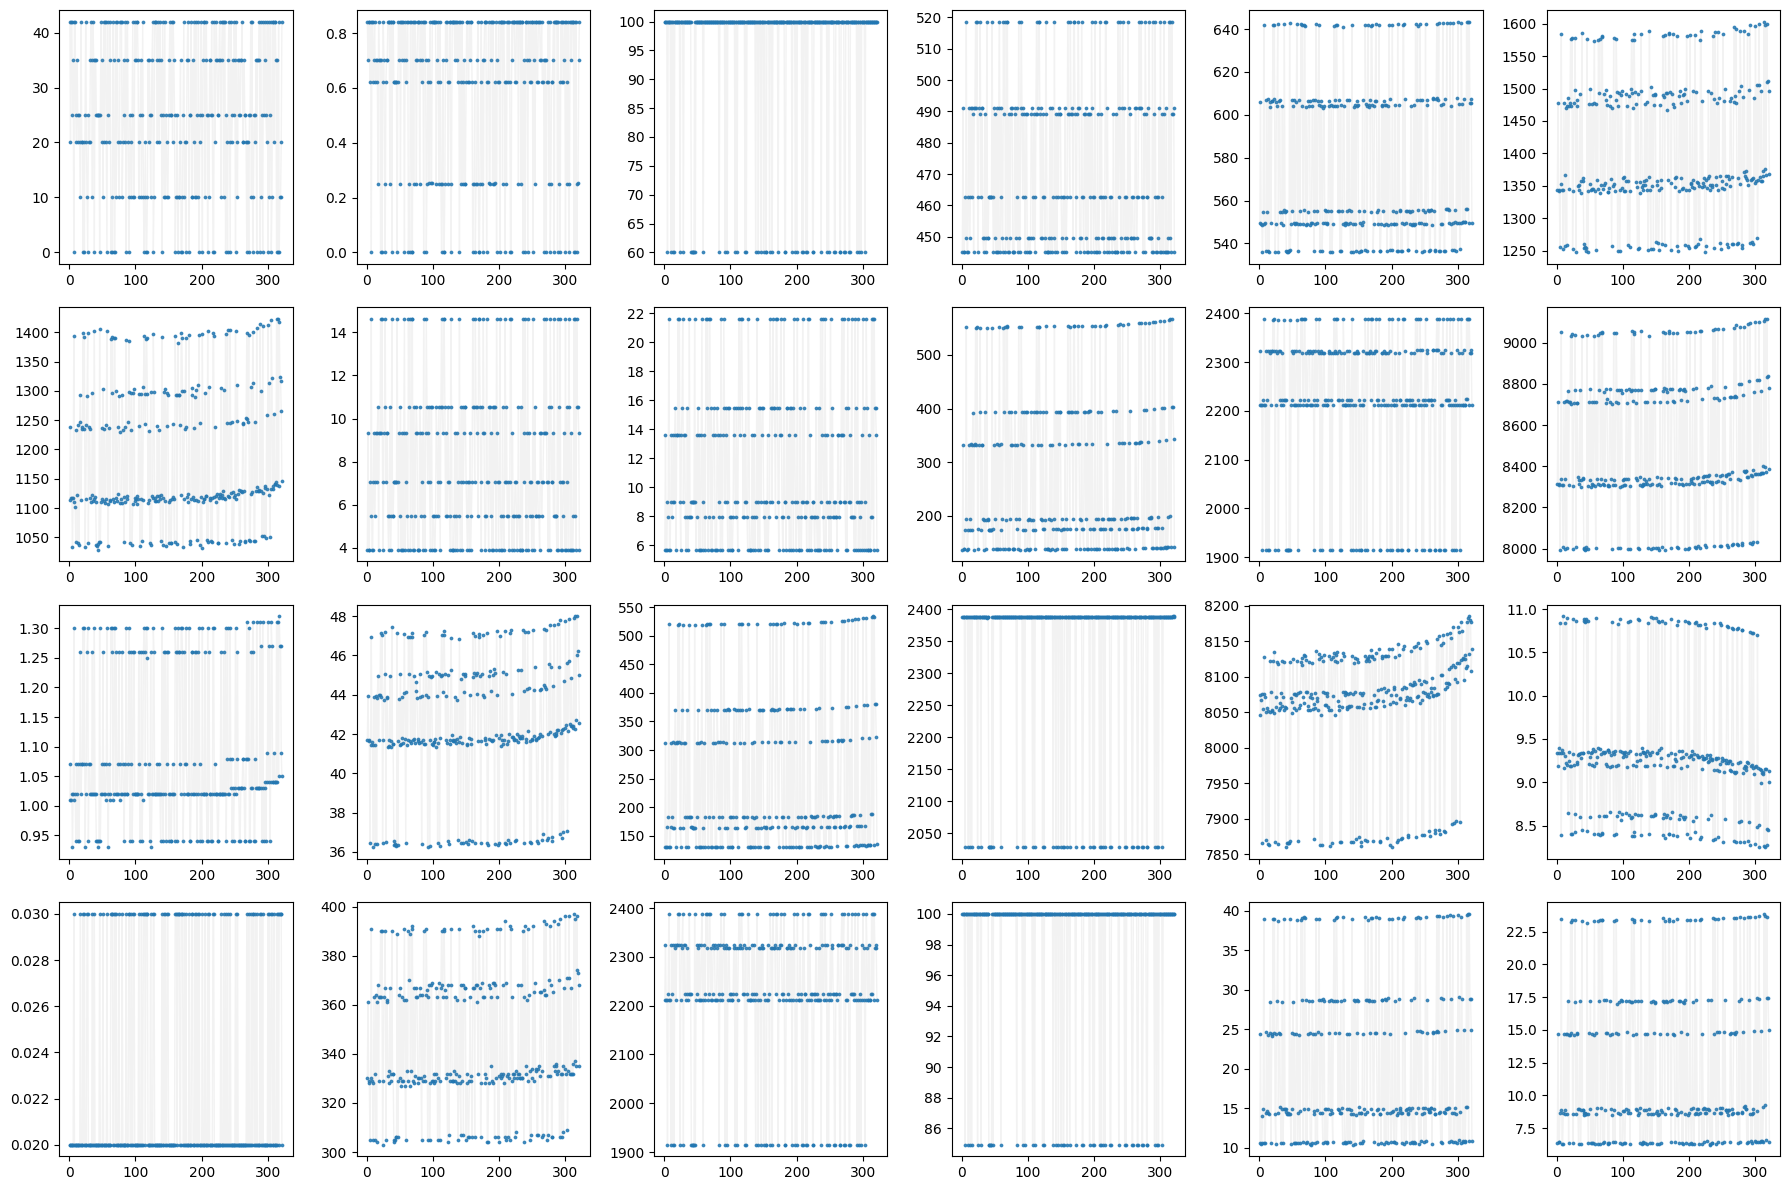

In [17]:
X_ds = df_source[df_source["id"] == 1]
X_dt = df_target[df_target["id"] == 1]

features = [xx for xx in X_ds.columns if "s" in xx]
print(features)

X_unit = X_dt.copy()

plt.clf()

fig, axs = plt.subplots(4, 6, figsize=(18, 12))

for irow in range(4):
    for icol in range(6):
        
        x, y = X_unit["cycle"], X_unit[features[int(irow*6+icol)]]
        
        axs[irow, icol].plot(x, y, c="gray", alpha=0.1, lw=1)
        axs[irow, icol].scatter(x, y, alpha=0.8, s=3)
        
plt.tight_layout()



visualizing all features for engine unit 1 for the both source and target doamins

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24']


<Figure size 640x480 with 0 Axes>

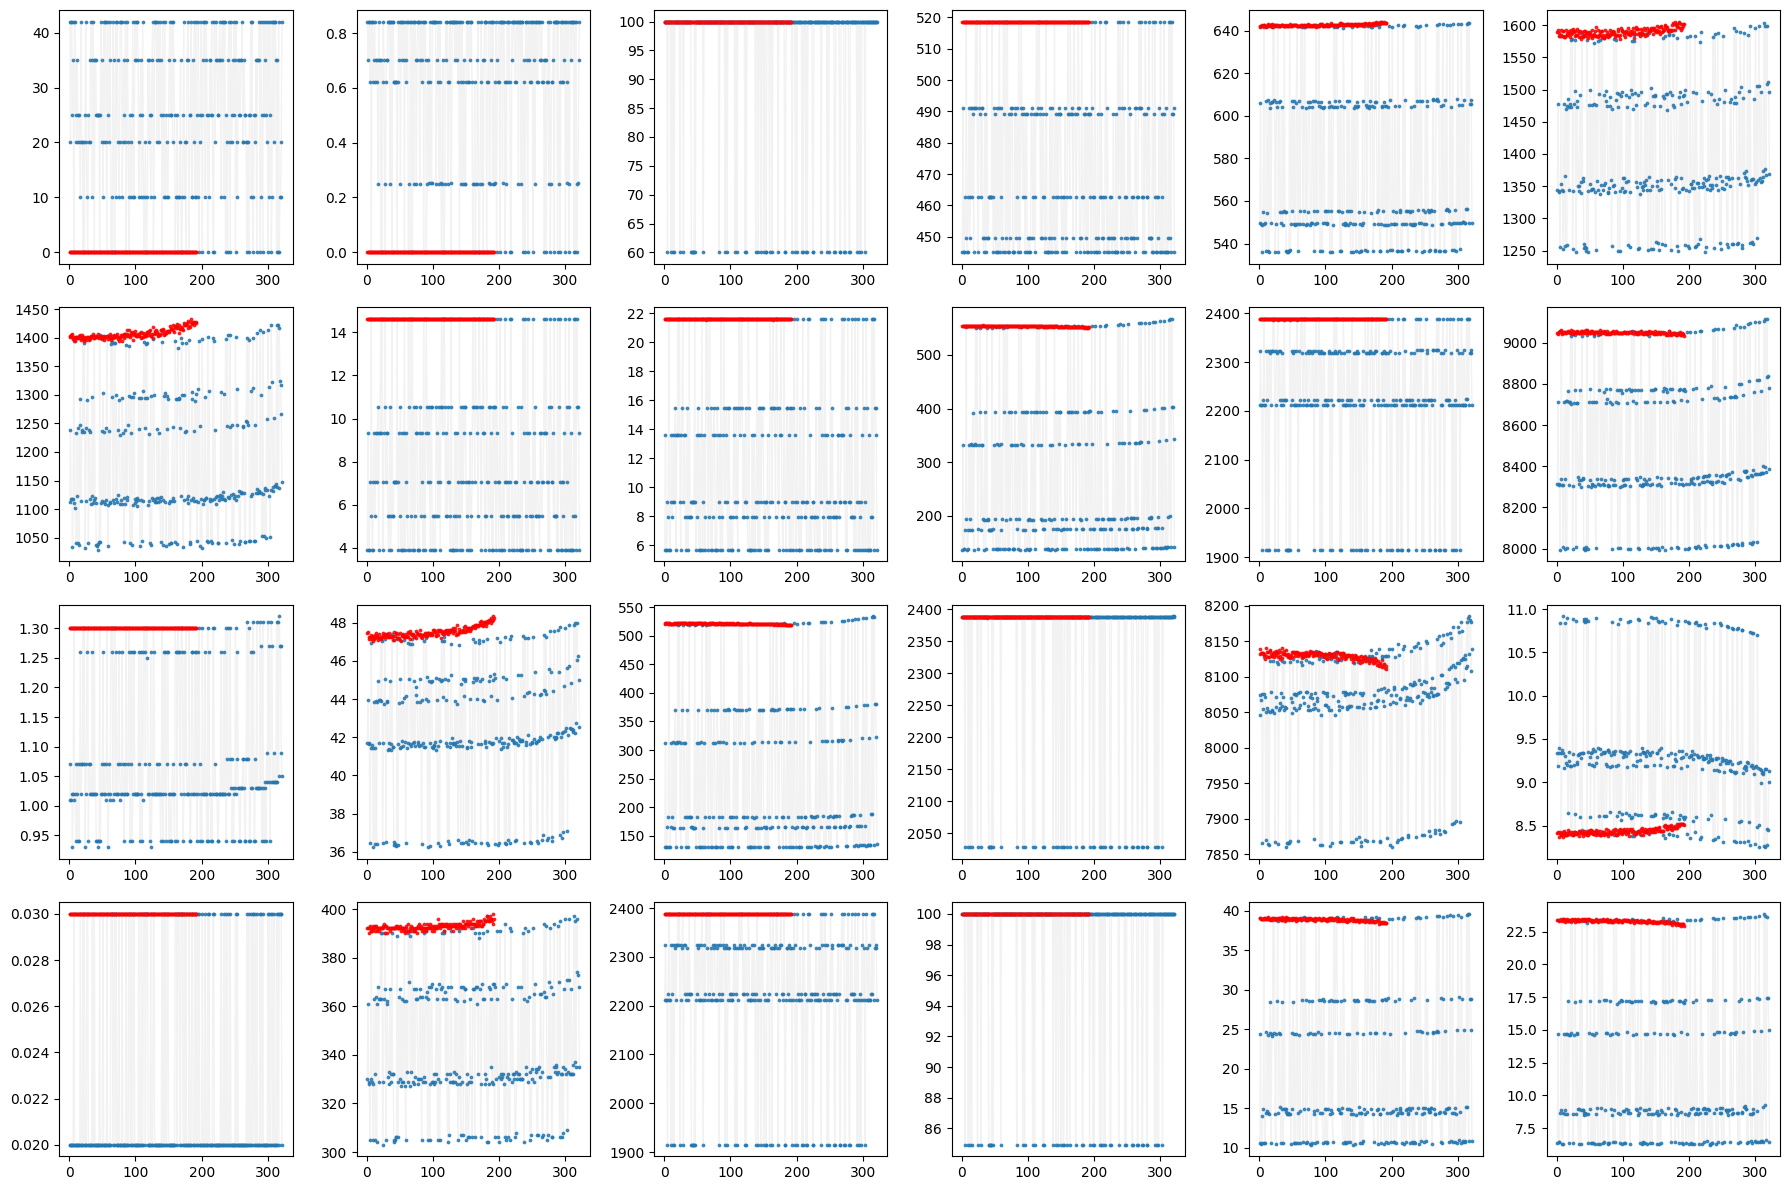

In [18]:
X_ds = df_source[df_source["id"] == 1]
X_dt = df_target[df_target["id"] == 1]

features = [xx for xx in X_ds.columns if "s" in xx]
print(features)

X_unit = X_dt.copy()

plt.clf()

fig, axs = plt.subplots(4, 6, figsize=(18, 12))

for irow in range(4):
    for icol in range(6):
        
        x, y = X_unit["cycle"], X_unit[features[int(irow*6+icol)]]
        
        axs[irow, icol].plot(x, y, c="gray", alpha=0.1, lw=1)
        axs[irow, icol].scatter(x, y, alpha=0.8, s=3)

        x_s, y_s = X_ds["cycle"], X_ds[features[int(irow*6+icol)]]
        axs[irow, icol].scatter(x_s, y_s, alpha=0.8, s=3, c='r')
        
plt.tight_layout()

As you can see, there are 6 operating conditions in the target domain. Source domain only captures one of the operating conditions. 

Now, to see these 6 operating conditions more clearly, we visualise them based on engineering features available in the dataset. 

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24']


<Figure size 640x480 with 0 Axes>

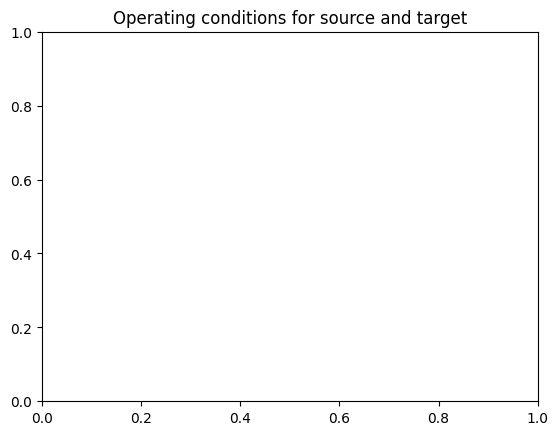

In [19]:
# visualizing all 6 operating conditions
# 6 operating conditions for the target domain, 1 for the source domain

from mpl_toolkits.mplot3d import Axes3D

X_ds = df_source[df_source["id"] == 1]
X_dt = df_target[df_target["id"] == 1]

features = [xx for xx in X_ds.columns if "s" in xx]
print(features)

x, y, s = X_dt["s1"], X_dt["s2"], X_dt["s3"]

plt.clf()

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter( X_dt["s1"],  X_dt["s2"],  X_dt["s3"], c='b')
ax.scatter( X_ds["s1"],  X_ds["s2"],  X_ds["s3"], c='r')

plt.title("Operating conditions for source and target")

plt.show()


We can also use TSNE to visualise the features in two dimentional space.
The colors show the RUL parameter. 

In [20]:
# visualization with TSNE

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import cm

features = [xx for xx in X_ds.columns if "s" in xx]
X_embedded_pack = []
unit_list = list(range(1, 11))

sample_x_u = df_source[df_source["id"].isin(unit_list)][features]
sample_y_u = df_source[df_source["id"].isin(unit_list)]["rul"]

X_embedded = TSNE(n_components=2).fit_transform(sample_x_u)

X_embedded_pack.append([X_embedded, sample_y_u])

cm_xs = np.linspace(.0, 1., 51)
colors_xs = [cm.autumn(x) for x in cm_xs]


Following, you can see the result of the TSNE visualisation of the features in source domain.

<ipython-input-13-5b9c3c9fad0a>:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_embedded[isample, 0], X_embedded[isample, 1], c=colors_xs[int(sample_y_u[isample])], marker='o', edgecolors=colors_xs[int(sample_y_u[isample])])


<Figure size 640x480 with 0 Axes>

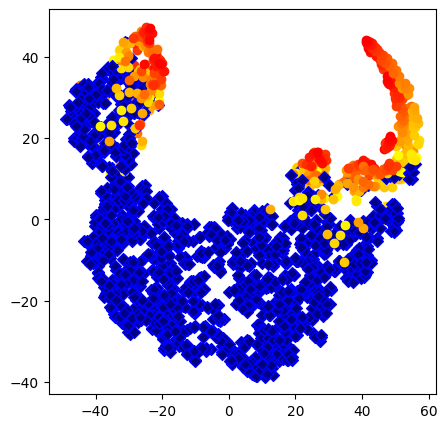

In [13]:
# Visualizing the TSNE for the source domain

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

plt.clf()
plt.figure(figsize=(5, 5))
for isample in range(len(sample_x_u)):

    if sample_y_u[isample] > 50:
        plt.scatter(X_embedded[isample, 0], X_embedded[isample, 1], c='navy', marker='D', edgecolors='b')
    else:
        plt.scatter(X_embedded[isample, 0], X_embedded[isample, 1], c=colors_xs[int(sample_y_u[isample])], marker='o', edgecolors=colors_xs[int(sample_y_u[isample])])


Can you try to visualize the target domain, what can you observe?

<ipython-input-21-4014bd0d73f4>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_embedded[isample, 0], X_embedded[isample, 1], c=colors_xs[int(sample_y_u[isample])], marker='o', edgecolors=colors_xs[int(sample_y_u[isample])])


<Figure size 640x480 with 0 Axes>

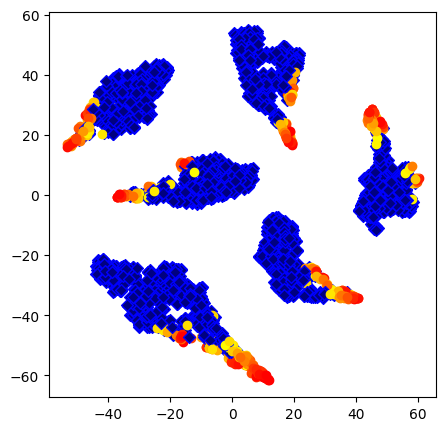

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import cm

features = [xx for xx in X_ds.columns if "s" in xx]
X_embedded_pack = []
unit_list = list(range(1, 11))

sample_x_u = df_target[df_target["id"].isin(unit_list)][features]
sample_y_u = df_target[df_target["id"].isin(unit_list)]["rul"]

X_embedded = TSNE(n_components=2).fit_transform(sample_x_u)

X_embedded_pack.append([X_embedded, sample_y_u])

cm_xs = np.linspace(.0, 1., 51)
colors_xs = [cm.autumn(x) for x in cm_xs]

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

plt.clf()
plt.figure(figsize=(5, 5))
for isample in range(len(sample_x_u)):

    if sample_y_u[isample] > 50:
        plt.scatter(X_embedded[isample, 0], X_embedded[isample, 1], c='navy', marker='D', edgecolors='b')
    else:
        plt.scatter(X_embedded[isample, 0], X_embedded[isample, 1], c=colors_xs[int(sample_y_u[isample])], marker='o', edgecolors=colors_xs[int(sample_y_u[isample])])


# Transfer Learning using COSMO feature

The COSMO feature is computed based on the distance to the peers, from the corresponding reference group. In this tutorial, the COSMO feature is computed sensor-wise and can be considered as an indicator of how different each sub-system of the equipment performs compared to its peers.



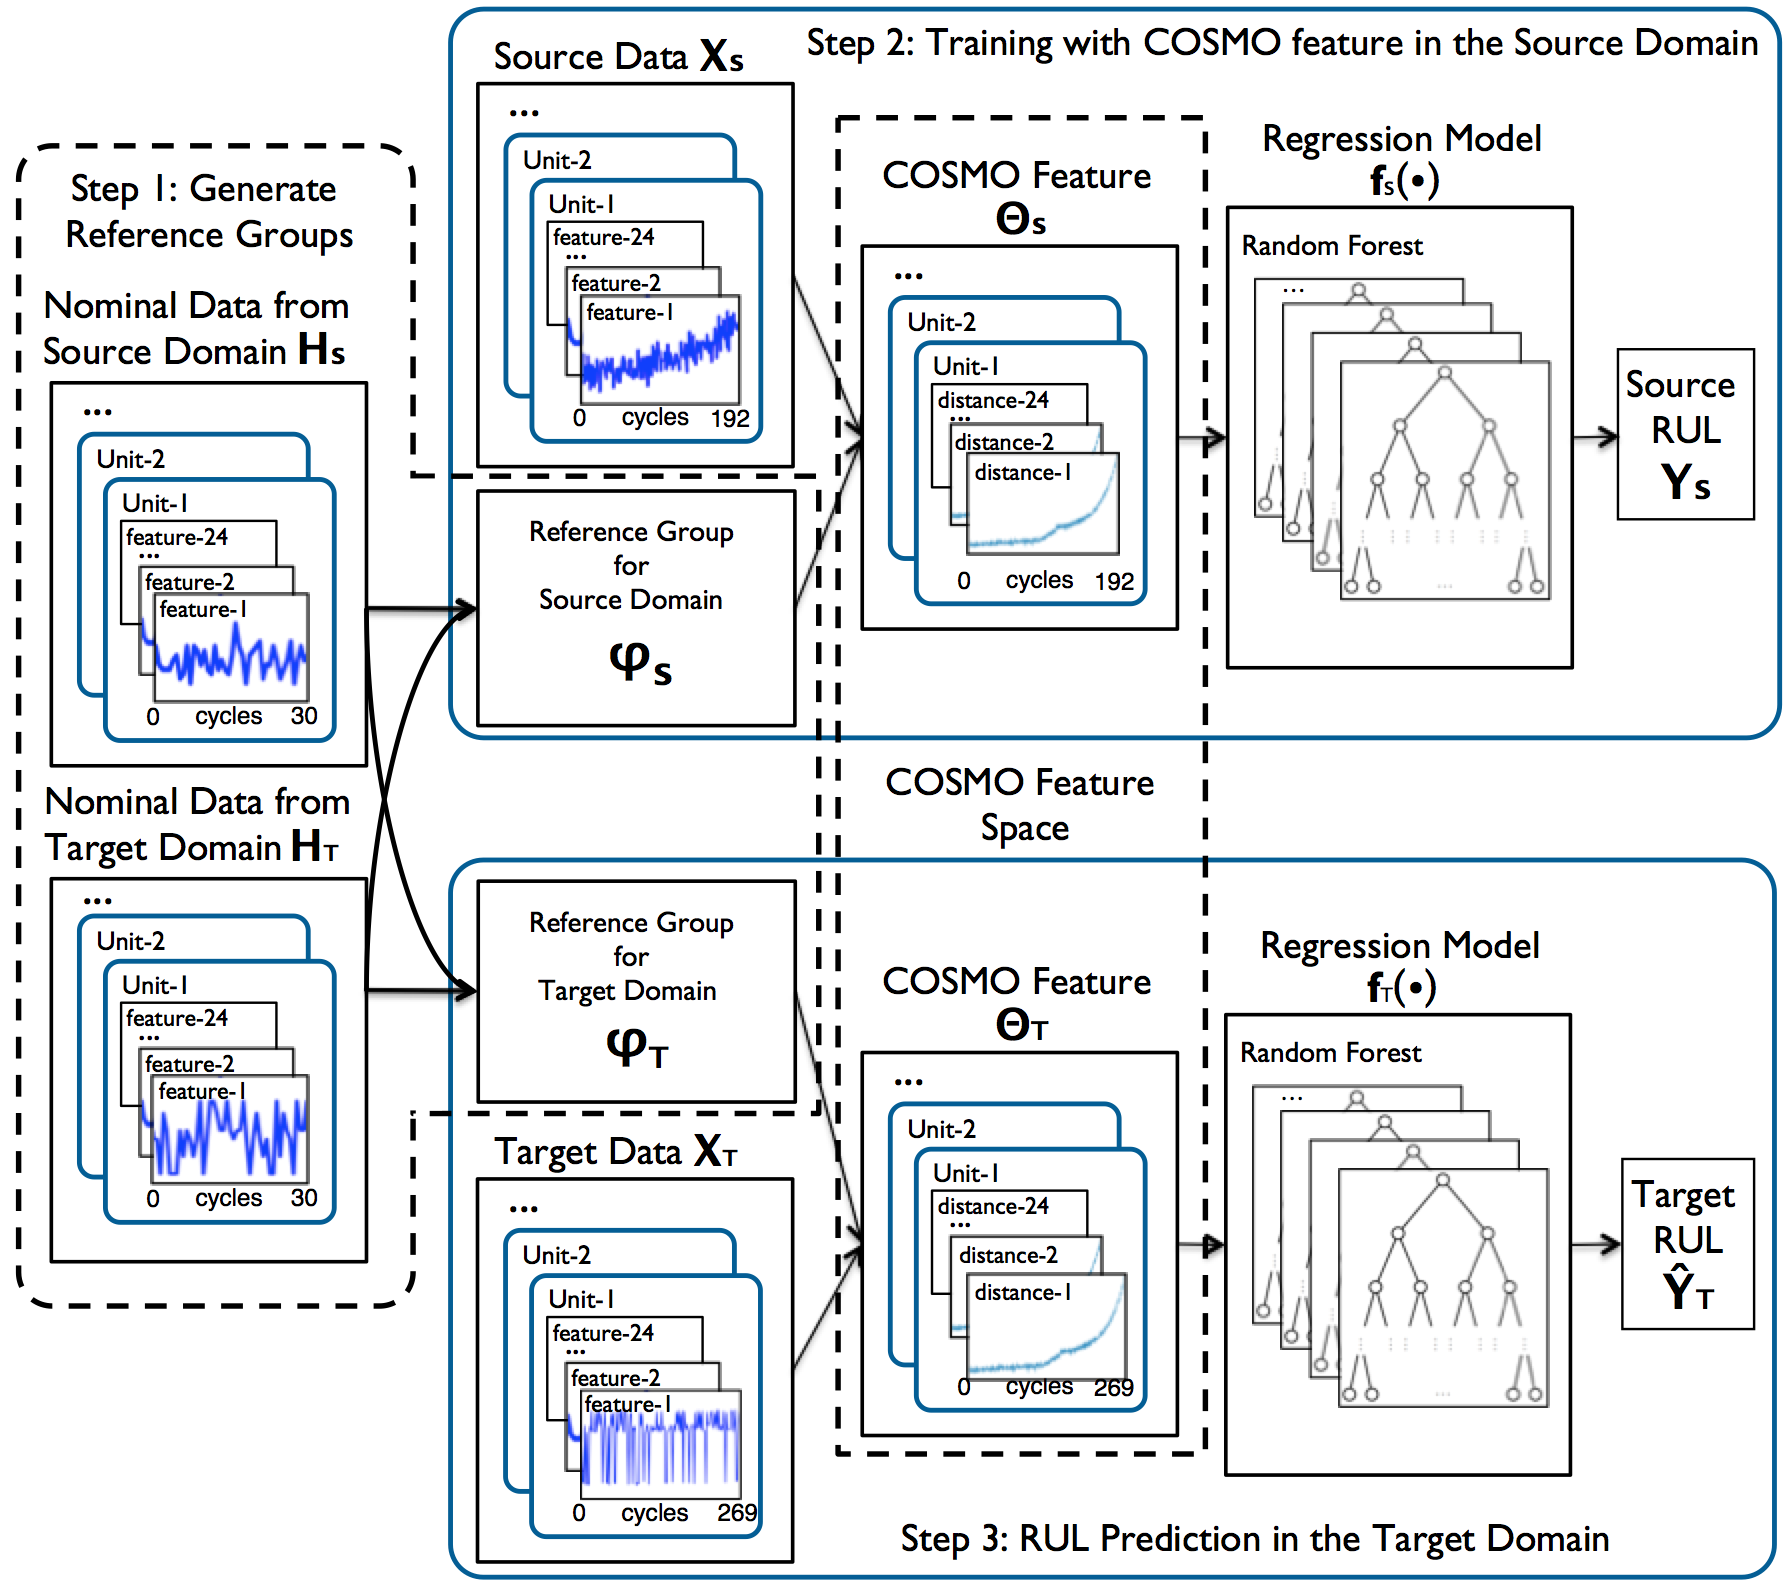

We start by preparing the data for the algorithm. We sample the data from source domainto create two disjoint set for training and testing time. We also sample data from target domain and use it for testing time.

In [23]:
# preparing samples

# set training and testing population for the source domain
# set testing population for the target domain
# make sure no information leakage

source_units = random.sample(list(df_source["id"].unique()), 40)
source_units_train = source_units[:20]
source_units_test = source_units[-20:]
target_units = random.sample(list(df_target["id"].unique()), 20)

print("selected source units", source_units)
print("selected target units", target_units)

selected source units [12, 29, 81, 96, 42, 37, 86, 85, 87, 93, 13, 39, 16, 60, 46, 17, 59, 36, 57, 4, 94, 26, 48, 77, 35, 67, 100, 5, 38, 43, 78, 40, 25, 15, 45, 7, 76, 95, 70, 34]
selected target units [214, 158, 54, 69, 47, 3, 108, 64, 195, 113, 37, 172, 205, 25, 84, 10, 145, 228, 58, 182]


## Scoring function
We use *mean absolute percentage error (MAPE)* as the scoring function which is commonly used as a loss function for regression problems. It measures the accuracy as a percentage by calculating mean absolute percentage of the difference between the actual value and predicted value divide by the predicted value.

In [24]:
# scoring function with mean absolute percentage error
# we weight near failure samples higher

def compute_mape(y_test, y_pred):
    ae = [abs(y_test[ix]-y_pred[ix])/y_test[ix] for ix, xx in enumerate(y_test) if y_test[ix] != 0]
    return np.mean(ae)

## Modeling the baseline model - random forest regressor

In [28]:
### traditional approach -- without any transfer learning ### 

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# prepating training and test sets on source damain
Xs = df_source[df_source["id"].isin(source_units_train)]
Xs_test = df_source[df_source["id"].isin(source_units_test)]

# prepating test set on target damain
Xt = df_target[df_target["id"].isin(target_units)]

x_var = [xx for xx in df_source.columns if xx != "rul"] 
target_var = "rul"
print(x_var)
print(target_var)

# training a random forest regressor on the source domain data
regr = RandomForestRegressor()
regr.fit(Xs[x_var], Xs[target_var])

# Testing on the source domain
y_test_ds = regr.predict(Xs_test[x_var])
mae_ds = metrics.mean_absolute_error(y_test_ds, Xs_test[target_var])
mse_ds = metrics.mean_squared_error(y_test_ds, Xs_test[target_var])
mape_ds = compute_mape(Xs_test[target_var].tolist(), y_test_ds)

# for the target domain
y_test_dt = regr.predict(Xt[x_var])
mae_dt = metrics.mean_absolute_error(y_test_dt, Xt[target_var])
mse_dt = metrics.mean_squared_error(y_test_dt, Xt[target_var])
mape_dt = compute_mape(Xt[target_var].tolist(), y_test_dt)

print("calculating performance measures on unseen data from source and target")
print("mean absolute error: ", mae_ds, mae_dt)
print("mean squared error: ", mse_ds, mse_dt)
print("mean absolute percentage error: ", mape_ds, mape_dt)


['id', 'cycle', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24']
rul
calculating performance measures on unseen data from source and target
mean absolute error:  14.319163568773233 34.95541616885703
mean squared error:  413.2206117100372 1583.3373046196734
mean absolute percentage error:  0.2555273970402693 1.3826073594134918


## Calculating COSMO (consensus self-organizing model) features
The cosmo feature is computed using distance to peers, here we only compute the distance to the k nearest neighbors.

For each data point, we compute the distance of it to the k nearest neighours in the reference group. reference group are samples which we selected as healthy samples.

In [41]:
ref_group_source = df_source.loc[(df_source["id"].isin(source_units_train)) & (df_source["cycle"] <= 10)]
ref_group_target = df_target.loc[(df_target["id"].isin(target_units)) & (df_target["cycle"] <= 10)]

mode = "knn"
nn_neighbour = 8
cosmo_var = [xx for xx in df_source.columns if xx not in ["rul", "id", "cycle"]]



ref_group_source
Xs_ = Xs.copy().reset_index()

for index, row in Xs.iterrows():

  kk = ref_group_source[cosmo_var] - row[cosmo_var]

  idx_neighnours = np.argpartition(np.linalg.norm(kk.values, axis=1), nn_neighbour)[:nn_neighbour]

  row_cosmo = kk.iloc[idx_neighnours].mean()

  X.iloc[index, X.columns.get_indexer(cosmo_var)] = row_cosmo

  break


row_cosmo


s1    -0.001775
s2    -0.000313
s3     0.000000
s4     0.000000
s5    -0.186250
s6     0.476250
s7     0.233750
s8     0.000000
s9     0.000000
s10   -0.152500
s11    0.003750
s12    0.182500
s13    0.000000
s14    0.130000
s15   -0.192500
s16   -0.008750
s17    0.666250
s18    0.002113
s19    0.000000
s20    0.000000
s21    0.000000
s22    0.000000
s23   -0.100000
s24   -0.020675
dtype: float64

In [48]:
### COSMO ###

# cosmo with knn distance (selecting k=8 peers in the reference group) for computing the cosmo feature
mode = "knn"
nn_neighbour = 15
cosmo_var = [xx for xx in df_source.columns if xx not in ["rul", "id", "cycle"]]

# sampling reference group for both the source and the target domain (healthy samples - first 10 cycles)
# TODO
ref_group_source = df_source.loc[(df_source["id"].isin(source_units_train)) & (df_source["cycle"] <= 10)]
ref_group_target = df_target.loc[(df_target["id"].isin(target_units)) & (df_target["cycle"] <= 10)]

### compute knn cosmo feature ###
# TODO
def compute_cosmo_feature(samples_tar, samples_ref):
    """
    Function computing the distance to peers, feature/sensor-wise, given the reference group samples

    Args: 
      samples_tar: dataframe, input data
      samples_ref: dataframe, should have the same column size as "samples_tar"
    
    return:
      X: dataframe, the COSMO feature of "samples_tar", given the reference group "samples_ref"

    """
    
    # compute cosmo features for the dataset
    X = samples_tar.copy().reset_index()

    for index, row in X.iterrows():
        
        # compute cosmo features for all signals
        kk = samples_ref[cosmo_var] - row[cosmo_var]

        # acquire k nearest neighbours - based on l2 norm
        idx_neighnours = np.argpartition(np.linalg.norm(kk.values, axis=1), nn_neighbour)[:nn_neighbour]
        
        # compute the mean value of the distance
        row_cosmo = kk.iloc[idx_neighnours].mean()

        X.iloc[index, X.columns.get_indexer(cosmo_var)] = row_cosmo

    return X

  

# compute cosmo feature for samples in different domains
cosmo_xs = compute_cosmo_feature(Xs, ref_group_source)
print("xs cosmo")

cosmo_xs_test = compute_cosmo_feature(Xs_test, ref_group_source)
print("xs test cosmo")

cosmo_xt = compute_cosmo_feature(Xt, ref_group_target)
print("xt cosmo")



xs cosmo
xs test cosmo
xt cosmo


<Figure size 640x480 with 0 Axes>

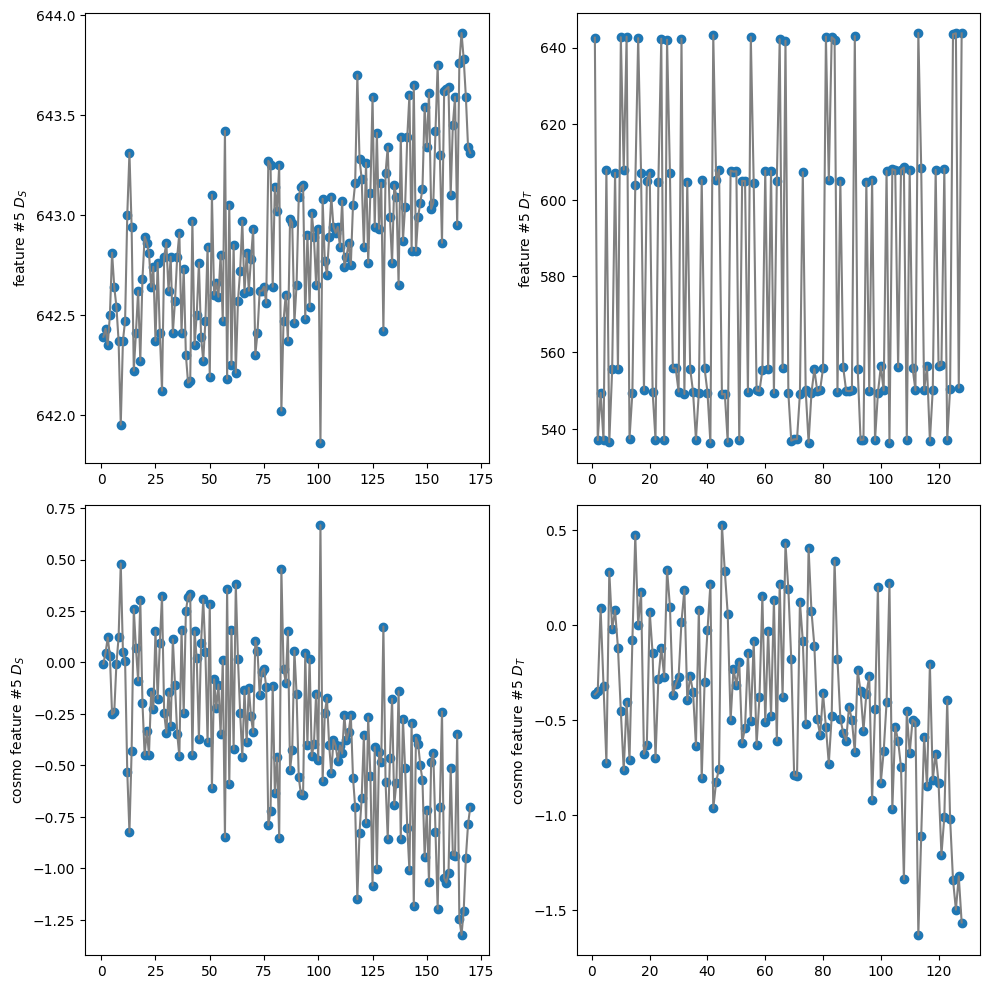

In [49]:
# visualization

id_source, id_target = source_units[0], target_units[0]

X_ds = Xs[Xs["id"] == id_source]
X_dt = Xt[Xt["id"] == id_target]

X_ds_cosmo = cosmo_xs[cosmo_xs["id"] == id_source]
X_dt_cosmo = cosmo_xt[cosmo_xt["id"] == id_target]


plt.clf()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].scatter(X_ds["cycle"], X_ds["s5"])
axs[0, 0].plot(X_ds["cycle"], X_ds["s5"], c="gray")
axs[0, 0].set_ylabel("feature #5 $D_S$")

axs[0, 1].scatter(X_dt["cycle"], X_dt["s5"])
axs[0, 1].plot(X_dt["cycle"], X_dt["s5"], c="gray")
axs[0, 1].set_ylabel("feature #5 $D_T$")

axs[1, 0].scatter(X_ds_cosmo["cycle"], X_ds_cosmo["s5"])
axs[1, 0].plot(X_ds_cosmo["cycle"], X_ds_cosmo["s5"], c="gray")
axs[1, 0].set_ylabel("cosmo feature #5 $D_S$")

axs[1, 1].scatter(X_dt_cosmo["cycle"], X_dt_cosmo["s5"])
axs[1, 1].plot(X_dt_cosmo["cycle"], X_dt_cosmo["s5"], c="gray")
axs[1, 1].set_ylabel("cosmo feature #5 $D_T$")

fig.tight_layout()
plt.show()




## Training random forest regressor on COSMO features

In [50]:
### fleet-based (sample-)representation transfer with COSMO ### 

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

Xs = df_source[df_source["id"].isin(source_units_train)]
Xs_test = df_source[df_source["id"].isin(source_units_test)]

Xt = df_target[df_target["id"].isin(target_units)]

x_var = [xx for xx in df_source.columns if xx != "rul"]
target_var = "rul"
print(x_var)
print(target_var)


regr = RandomForestRegressor()
regr.fit(cosmo_xs[x_var], cosmo_xs[target_var])

# for the source domain

y_test_ds = regr.predict(cosmo_xs_test[x_var])
mae_ds = metrics.mean_absolute_error(y_test_ds, cosmo_xs_test[target_var])
mse_ds = metrics.mean_squared_error(y_test_ds, cosmo_xs_test[target_var])
mape_ds = compute_mape(cosmo_xs_test[target_var].tolist(), y_test_ds)

# for the target domain

y_test_dt = regr.predict(cosmo_xt[x_var])
mae_dt = metrics.mean_absolute_error(y_test_dt, cosmo_xt[target_var])
mse_dt = metrics.mean_squared_error(y_test_dt, cosmo_xt[target_var])
mape_dt = compute_mape(cosmo_xt[target_var].tolist(), y_test_dt)


print("calculating performance measures on unseen data from source and target")
print("mean absolute error: ", mae_ds, mae_dt)
print("mean squared error: ", mse_ds, mse_dt)
print("mean absolute percentage error: ", mape_ds, mape_dt)



['id', 'cycle', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24']
rul
calculating performance measures on unseen data from source and target
mean absolute error:  13.804086895910782 21.814293110314615
mean squared error:  376.7641849210037 741.4778711668657
mean absolute percentage error:  0.22283158845707476 0.7729767922321256


# References
If you would like to know about how to use this algorithm, you can check out following papers:
* Fan, Yuantao, Sławomir Nowaczyk, and Thorsteinn Rögnvaldsson. "Transfer learning for remaining useful life prediction based on consensus self-organizing models." Reliability Engineering & System Safety 203 (2020): 107098.
* Fan, Yuantao, Sławomir Nowaczyk, Thorsteinn Rögnvaldsson, and Eric Aislan Antonelo. "Predicting air compressor failures with echo state networks." PHM Society European Conference. Vol. 3. No. 1. 2016.
* Rögnvaldsson, T., Nowaczyk, S., Byttner, S. et al. Self-monitoring for maintenance of vehicle fleets. Data Min Knowl Disc 32, 344–384 (2018). https://doi.org/10.1007/s10618-017-0538-6


